In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats

In [2]:
df = pd.read_excel('AtlanticStormTotalsTable.xlsx', header=1)
df.set_index(df['Year'], inplace=True)
df.drop('Year', axis=1, inplace=True)
cols = df.columns.tolist()
cols = [col.replace(' ', '_') for col in cols]
df.columns = cols

In [15]:
y_9 = df['Tropical_Storms'].rolling(window=9, center=False).mean()

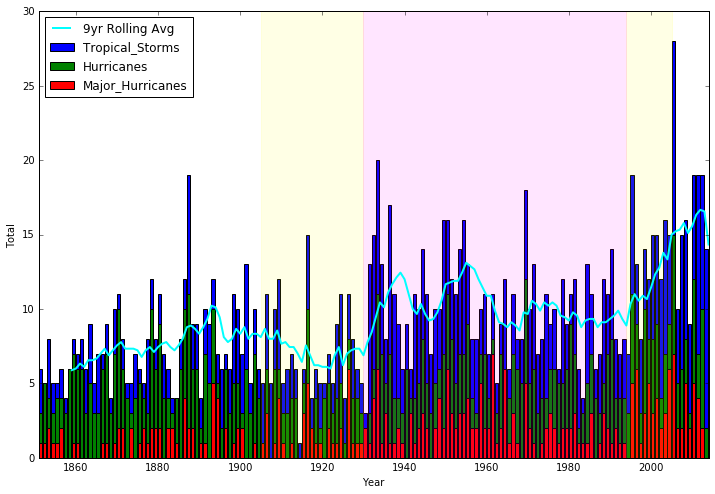

In [46]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.bar(df.index, df['Tropical_Storms'], label='Tropical_Storms')
ax.bar(df.index, df['Hurricanes'], label='Hurricanes', color='green')
ax.bar(df.index, df['Major_Hurricanes'], label='Major_Hurricanes', color='red')
ax.plot(df.index, y_9, label='9yr Rolling Avg', color='cyan', lw=2)
ax.axvspan(1905, 1930, alpha=0.1, color='yellow')
ax.axvspan(1930, 1994, alpha=0.1, color='magenta')
ax.axvspan(1994, 2005, alpha=0.1, color='yellow')
ax.set_xlim(1851, 2014)
ax.set_xlabel('Year')
ax.set_ylabel('Total')
plt.legend(loc='upper left')

Tropical Storm Analysis

In [58]:
import pymc3 as pm
import theano.tensor as tt

count_data = df['Tropical_Storms'][80:].values
n_count_data = len(df['Tropical_Storms'][80:])
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

Applied log-transform to lambda_1 and added transformed lambda_1_log_ to model.
Applied log-transform to lambda_2 and added transformed lambda_2_log_ to model.


In [59]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = tt.switch(tau >= idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=count_data)

    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 10000/10000 [00:02<00:00, 3460.21it/s]


In [60]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

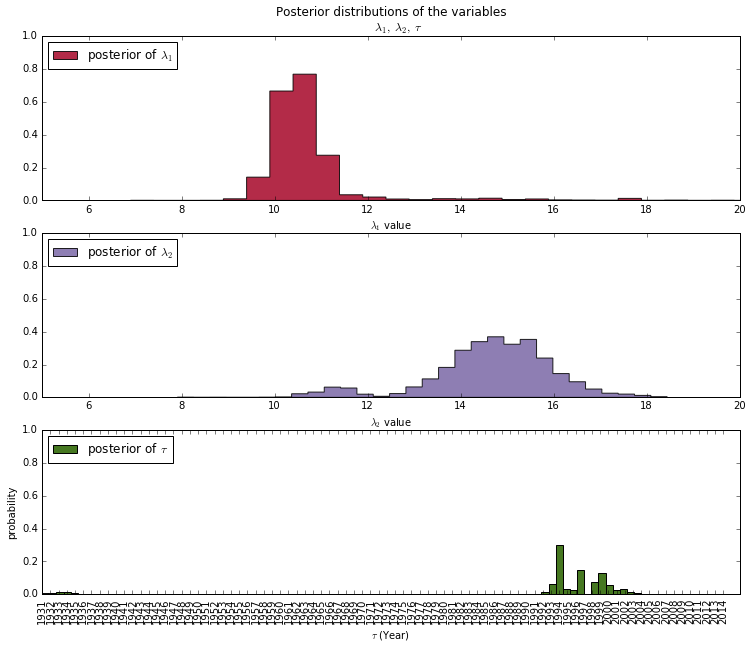

In [61]:
fig = plt.figure(figsize=(12.5,10))
ax = fig.add_subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([5, 20])
plt.xlabel("$\lambda_1$ value")

ax = fig.add_subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([5, 20])
plt.xlabel("$\lambda_2$ value")

ax = fig.add_subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
y, x ,_ = plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data), df.index[80:], rotation='vertical')

plt.legend(loc="upper left")
plt.ylim([0, 1.0])
plt.xlim([0, 85])
plt.xlabel(r"$\tau$ (Year)")
plt.ylabel("probability");

In [62]:
print 'Switchpoint: {0}, {1} prob'.format(int(round(x[np.argmax(y)] + 1931, 0)), round(y.max(), 3))

Switchpoint: 1994, 0.301 prob


In [63]:
print 'Lambda_1: {0}, Lambda_2: {1}'.format(round(np.mean(lambda_1_samples), 2), round(np.mean(lambda_2_samples), 2))

Lambda_1: 10.68, Lambda_2: 14.66


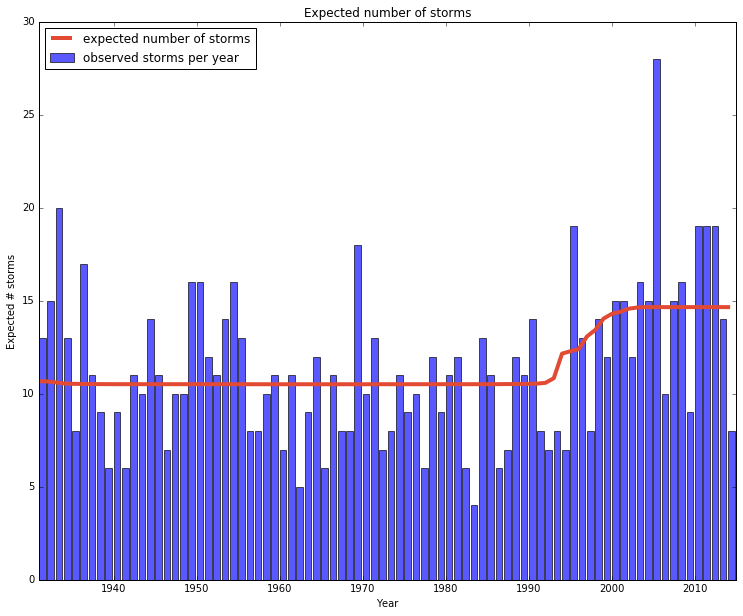

In [65]:
N = tau_samples.shape[0]
expected_storms_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_storms_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

fig = plt.figure(figsize=(12.5,10))
plt.plot(df.index[80:], expected_storms_per_day, lw=4, color="#E24A33",
         label="expected number of storms")
plt.xlim(1931, 2015)
plt.xlabel("Year")
plt.ylabel("Expected # storms")
plt.title("Expected number of storms")
plt.ylim(0, 30)
plt.bar(df.index[80:], count_data, color="blue", alpha=0.65,
        label="observed storms per year")

plt.legend(loc="upper left");

In [48]:
count_data = df['Tropical_Storms'][:80].values
n_count_data = len(df['Tropical_Storms'][:80])
with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data)

Applied log-transform to lambda_1 and added transformed lambda_1_log_ to model.
Applied log-transform to lambda_2 and added transformed lambda_2_log_ to model.


In [49]:
with model:
    idx = np.arange(n_count_data) # Index
    lambda_ = tt.switch(tau >= idx, lambda_1, lambda_2)

    observation = pm.Poisson("obs", lambda_, observed=count_data)

    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

100%|██████████| 10000/10000 [00:04<00:00, 2400.84it/s]


In [50]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

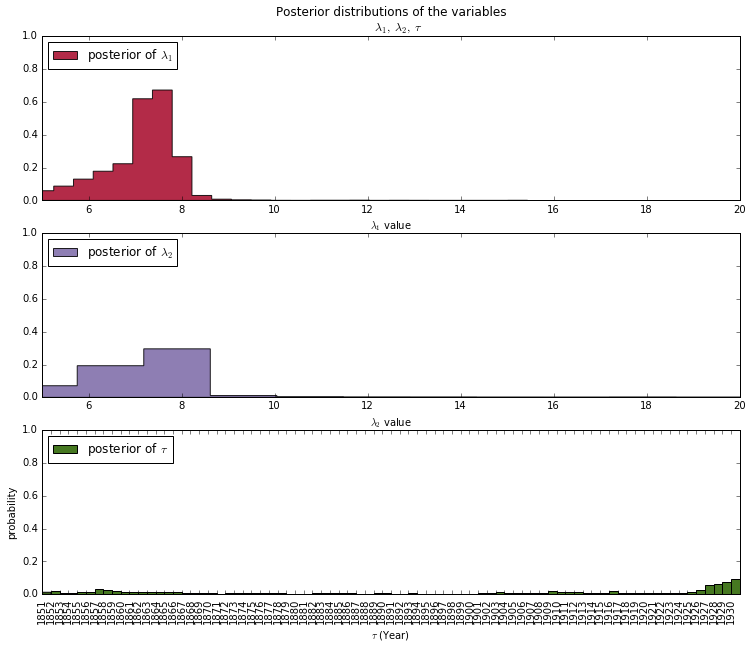

In [53]:
fig = plt.figure(figsize=(12.5,10))
ax = fig.add_subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", normed=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([5, 20])
plt.xlabel("$\lambda_1$ value")

ax = fig.add_subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", normed=True)
plt.legend(loc="upper left")
plt.xlim([5, 20])
plt.xlabel("$\lambda_2$ value")

ax = fig.add_subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
y, x ,_ = plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data), df.index[:80], rotation='vertical')

plt.legend(loc="upper left")
plt.ylim([0, 1.0])
plt.xlim([0, 80])
plt.xlabel(r"$\tau$ (Year)")
plt.ylabel("probability");

In [54]:
print 'Switchpoint: {0}, {1} prob'.format(int(round(x[np.argmax(y)] + 1931, 0)), round(y.max(), 3))

Switchpoint: 2010, 0.095 prob


In [55]:
print 'Lambda_1: {0}, Lambda_2: {1}'.format(round(np.mean(lambda_1_samples), 2), round(np.mean(lambda_2_samples), 2))

Lambda_1: 7.03, Lambda_2: 6.62


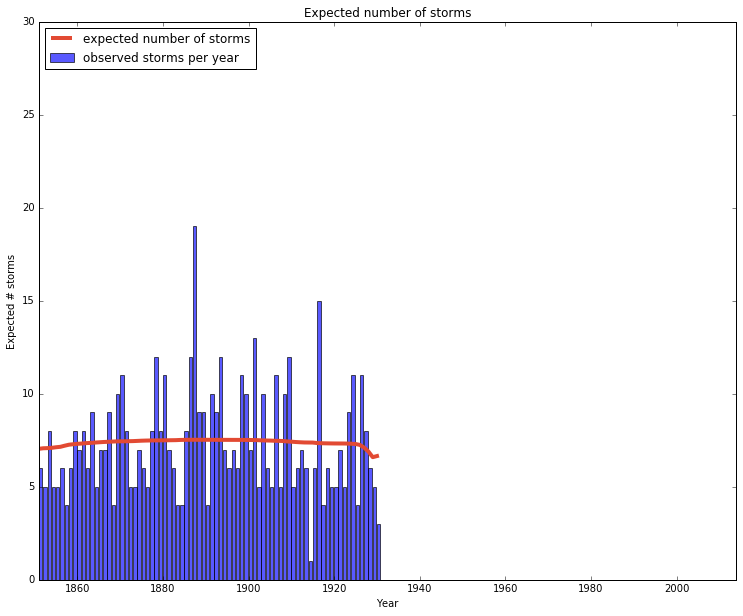

In [57]:
N = tau_samples.shape[0]
expected_storms_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    ix = day < tau_samples
    expected_storms_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N

fig = plt.figure(figsize=(12.5,10))
plt.plot(df.index[:80], expected_storms_per_day, lw=4, color="#E24A33",
         label="expected number of storms")
plt.xlim(1851, 2014)
plt.xlabel("Year")
plt.ylabel("Expected # storms")
plt.title("Expected number of storms")
plt.ylim(0, 30)
plt.bar(df.index[:80], count_data, color="blue", alpha=0.65,
        label="observed storms per year")

plt.legend(loc="upper left");